# ML Model with TFIDF for text based classification

In [1]:
import os
import itertools
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, linear_model, naive_bayes, svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import pickle

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Load Dataset as pandas dataframe.used dropna as there are 55 rows with no words
train_df=pd.read_csv('shuffled-full-set-hashed.csv').dropna(axis = 0)

In [3]:
# Rename the dataframe columns to readable text
column_names = list(train_df)
train_df = train_df.rename(index = str, columns = {column_names[0]: 'class', column_names[1]: 'words'})

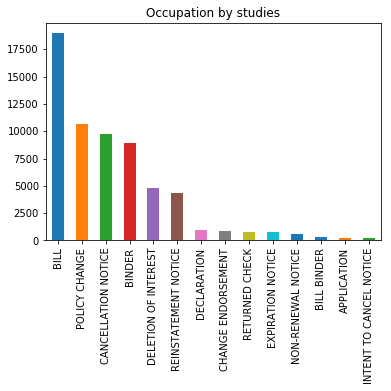

In [4]:
# Plot the graph to get the number of classes vs number of documents
train_df['class'].value_counts().plot(kind='bar',title='Occupation by studies')
plt.show()

 From the graph we see the dataset is biased more with Bill, Policy change, .... We can try to balance the dataset by reducing these rows or replicate the rows for less dominating classes. For now we are using the entire dataset and how the models perform. 

In [5]:
# Basic feature processing by Fitting the training documents into a Tfidf vectorizer for prediction
# Can use stop words if we get the original dataset.
# Can implement ngram or NLP techinques for further processing if needed. 
count_vect = TfidfVectorizer( min_df = 0.0295, max_features=4000)
x = count_vect.fit_transform(train_df['words'])

In [6]:
# Get number of times a word appears in the entire document list. Atleast a word appears in 100 documents.
occ = np.asarray(x.sum(axis=0)).ravel().tolist()
counts_df = pd.DataFrame({'term': count_vect.get_feature_names(), 'occurrences': occ})
counts_df.sort_values(by='occurrences', ascending=True).head(5)

,term,occurrences
407,6f6fb5a7797f,93.749694
859,e8b3fc9fa86a,95.986273
440,7846c4b0c98a,100.304268
203,3540f4612edb,102.005614
347,5ffca64090ab,104.377521


In [7]:
# Get the sparsity, shape and non zero count of the train features
print ('sparse matrix shape:', x.shape)
print ('nonzero count:', x.nnz)
print ('sparsity: %.2f%%' % (100.0 * x.nnz / (x.shape[0] * x.shape[1])))

sparse matrix shape: (62158, 961)
nonzero count: 6886186
sparsity: 11.53%


In [8]:
# Split the dataset into train and test sets for validation of the model.
X_train, X_test, y_train, y_test = model_selection.train_test_split(x.toarray(), train_df['class'], test_size=0.20, random_state=42)

In [9]:
# testing on different classifiers
classifers = {'nb': naive_bayes.GaussianNB(), 
              'nn': MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1), 
              'linear': linear_model.LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial'),
              'rf' : RandomForestClassifier()
             }


In [10]:
# Predictions and models stored in a dictionary to be used in future. 
predictions ={}
models = {}
for clf in classifers:
    print ('Model Training: {}'.format(clf))
    models[clf] = classifers[clf].fit(X_train,y_train)
    predictions[clf] = models[clf].predict(X_test)

Model Training: nb
Model Training: nn
Model Training: linear


/home/nikhila/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/nikhila/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Model Training: rf


In [11]:
# Getting the accuracy for the fitted models. 
for clf in predictions.keys():
    acc = accuracy_score(y_test, predictions[clf])
    print ('Accuracy for {} model: {}'.format(clf,acc*100))

Accuracy for nb model: 59.475546975546976
Accuracy for nn model: 64.02831402831403
Accuracy for linear model: 85.96364221364222
Accuracy for rf model: 85.02252252252252


In [12]:
# Usinig Ensemble classifer- Random forest which performed better compared to other models. 
final = classifers['linear'].fit(x.toarray(), train_df['class'])

/home/nikhila/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [13]:
# Confusion matrix for measuring the performance of the model to check the predictions for all the classes.
li = train_df['class'].unique()
matrix = confusion_matrix(y_test, predictions['linear'])
print ('Confusion matrix for Linear model')
print (matrix)

Confusion matrix for Linear model
[[  24    5    0    8    0    0    0    0    0    0    0    4    0    0]
 [   2 3413    5   67  145    1    6    2    9    0    1  114    4    1]
 [   0   39    3   10    0    0    0    0    1    0    0   12    0    0]
 [   2   56    1 1527   13    3   13    2    0    0    0  156    1    1]
 [   0  113    0   14 1714    0    3   65    2    0    4   40   37    0]
 [   1    1    0    2    1  153    0    1    0    0    0   26    1    0]
 [   2   33    0   75    8    1   40   10    0    0    2   30    3    1]
 [   0    0    0    3   80    1    1  865    0    0    0    7    0    1]
 [   0   42    0    1    3    0    0    0  106    0    2    7    1    0]
 [   0    8    0    3   27    0    2    0    0   13    0    1    0    0]
 [   0    0    0    0    8    0    0    1    0    0  104    8    0    0]
 [   1  112    0  109   20    9    1    9    6    0    3 1818   16    0]
 [   0   10    0    6   29    0    2    7    0    0    2   14  785    0]
 [   0    2    0 

In [14]:
# Test for sample prediction
check = ['586242498a88 9ccf259ca087 54709b24b45f 6bf9c0cb01b4 3486e5fe0d73 c337a85b8ef9 b2125dcdb706 f1424da4e7d6 5defc9f531f0 7ec02e30a5b3 f9e92c0357ef 6753b57205cb 5488cb2c0749 1ec85e7e2142 2685f0879380 b2125dcdb706 f1424da4e7d6 5defc9f531f0 b834a58b85b9 036087ac04f9 2bcce4e05d9d 6ca2dd348663 d38820625542 c9a53ea6e219 6dae7d5c1d03 1aba273fa8e4 0d66aace12f3 b6670dfb5ae7 5be138559904 b2125dcdb706 f1424da4e7d6 5defc9f531f0 b834a58b85b9 036087ac04f9 b136f6349cf3 186c2a8b23eb 7772cb33d419 e943e5e5b779 7a5e719bafba cbfb3eb99bea d38820625542 9287e6d15453 c85a9f2e0024 1c303d15eb65 351248ac109a 5ee06767bc0f ed1e3242ee34 cc27fc4409a9 4ce4bfb42e22 63e05aeec02b b9699ce57810 641356219cbc b2125dcdb706 f1424da4e7d6 5defc9f531f0 831d93352e04 21e314d3afcc ebbd827fe2a0 641356219cbc 422068f04236 d19b1c129f40 b9699ce57810 b834a58b85b9 f0666bdbc8a5 036087ac04f9 eeb86a6a04e4 2bcce4e05d9d 48d657cd9861 b643c02ad43a 831d93352e04 21e314d3afcc 2e182c67811b 641356219cbc d19b1c129f40 6ca2dd348663 831d93352e04 21e314d3afcc d38820625542 6bf9c0cb01b4 3486e5fe0d73 c337a85b8ef9 c9a53ea6e219 f7ae6f8257da 6dae7d5c1d03 b2125dcdb706 ecee69844b4e f1424da4e7d6 36e7aa72ffe1 5defc9f531f0 0302af775b89 7e0ebc43dbc1 1015893e384a 28ddf393019c 586242498a88 54709b24b45f 7ec02e30a5b3 5fa62998872f f9e92c0357ef 9f11111004ec 0ad17934ee05 c337a85b8ef9 be9f9e5522c9 446c804d79cc 6753b57205cb f7ae6f8257da eeb86a6a04e4 586242498a88 641356219cbc 446c804d79cc 5488cb2c0749 eeb86a6a04e4']
r = count_vect.transform(check)
print ('Prediction test: {}'.format(final.predict(r)[0]))

Prediction test: BILL


Save the model and vectorizer to be used for prediction API

In [15]:
# Save the Training model fitted with the entire dataset.
pickle.dump(final, open('model.pkl', 'wb'))

In [16]:
# Save the TfidfVectorizer fitted with the training data.
pickle.dump(count_vect, open("tfidf.pkl", "wb"))